# Interpolation from 2D sem mesh

Our interpolation routines work mostly for 3D fields, therefore here we show a workaround by converting 2D fields into 3D fields with one element

#### Import general modules

In [1]:
# Import required modules
from mpi4py import MPI #equivalent to the use of MPI_init() in C
import matplotlib.pyplot as plt
import numpy as np

# Get mpi info
comm = MPI.COMM_WORLD

#### Import modules from pynektools

In [2]:
from pynektools.io.ppymech.neksuite import pynekread
from pynektools.datatypes.msh import Mesh
from pynektools.datatypes.coef import Coef
from pynektools.datatypes.field import FieldRegistry

## Read the data and build objects

In this instance, we create connectivity for the mesh object, given that we wish to use direct stiffness summation to reduce discontinuities.

In [3]:
msh = Mesh(comm, create_connectivity=True)
fld = FieldRegistry(comm)
pynekread('../data/mixlay0.f00001', comm, data_dtype=np.double, msh=msh, fld=fld)
coef = Coef(msh, comm, get_area=False)

2024-08-26 08:37:50,343 - Mesh - INFO - Initializing empty Mesh object.
2024-08-26 08:37:50,344 - Field - INFO - Initializing empty Field object
2024-08-26 08:37:50,345 - pynekread - INFO - Reading file: ../data/mixlay0.f00001
2024-08-26 08:37:50,359 - Mesh - INFO - Initializing Mesh object from x,y,z ndarrays.
2024-08-26 08:37:50,360 - Mesh - INFO - Initializing common attributes.
2024-08-26 08:37:50,361 - Mesh - INFO - Creating connectivity
2024-08-26 08:37:50,545 - Mesh - INFO - Mesh object initialized.
2024-08-26 08:37:50,545 - Mesh - INFO - Mesh data is of type: float64
2024-08-26 08:37:50,546 - Mesh - INFO - Elapsed time: 0.18645260199999994s
2024-08-26 08:37:50,546 - pynekread - INFO - Reading field data
2024-08-26 08:37:50,553 - pynekread - INFO - File read
2024-08-26 08:37:50,554 - pynekread - INFO - Elapsed time: 0.209186977s
2024-08-26 08:37:50,555 - Coef - INFO - Initializing Coef object
2024-08-26 08:37:50,555 - Coef - INFO - Getting derivative matrices
2024-08-26 08:37:50

### Plot the 2D velocity field

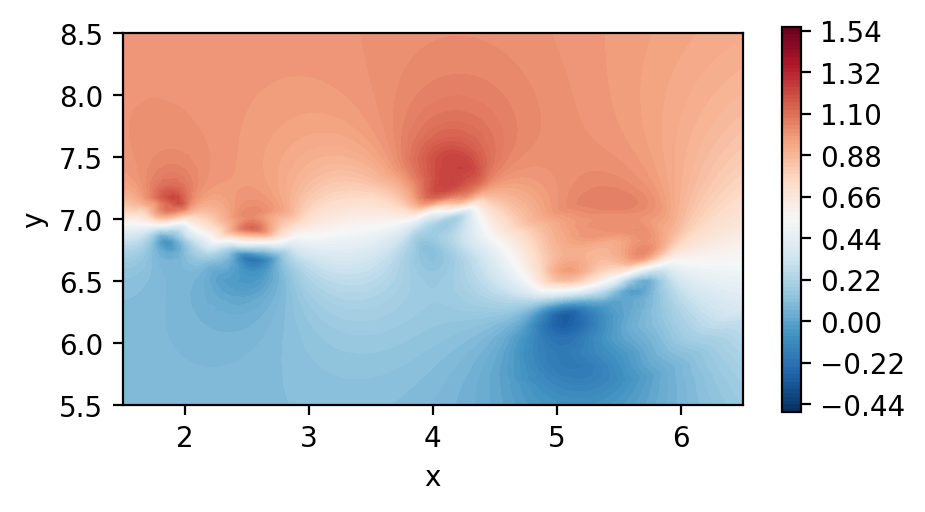

In [4]:
fig, ax = plt.subplots(figsize=(5, 2.5), dpi = 200)
c = ax.tricontourf(msh.x.flatten(), msh.y.flatten() ,fld.registry["u"].flatten(), levels=100, cmap="RdBu_r")
fig.colorbar(c)
ax.set_aspect('equal')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim([1.5,6.5])
ax.set_ylim([5.5,8.5])
plt.show()

## Extrude the mesh to be one element deep

For this we can simply use a helper function

In [5]:
# Import helper function
from pynektools.datatypes.utils import extrude_2d_sem_mesh

# Extrude the 2D mesh to 3D
msh3d, fld3d = extrude_2d_sem_mesh(comm, lz = msh.lx, msh = msh, fld = fld)

2024-08-26 08:37:51,889 - Mesh - INFO - Initializing Mesh object from x,y,z ndarrays.
2024-08-26 08:37:51,890 - Mesh - INFO - Initializing common attributes.
2024-08-26 08:37:51,891 - Mesh - INFO - Creating connectivity
2024-08-26 08:37:52,615 - Mesh - INFO - Mesh object initialized.
2024-08-26 08:37:52,616 - Mesh - INFO - Mesh data is of type: float64
2024-08-26 08:37:52,617 - Mesh - INFO - Elapsed time: 0.7274203159999999s
2024-08-26 08:37:52,618 - Field - INFO - Initializing empty Field object


## Generate interpolation points

The interpolation points must have 3 coordinates, so we simply set the z limits to be zero, since in our extrudex 3d mesh, zero is part of the extruded dimension

In [6]:
# Import helper functions
import pynektools.interpolation.utils as interp_utils
import pynektools.interpolation.pointclouds as pcs


if comm.Get_rank() == 0 :
    # Generate the bounding box of the points
    x_bbox = [1.5, 6.5]
    y_bbox = [5.5, 8.5]
    z_bbox = [0,0]
    nx = 100
    ny = 100
    nz = 1
    
    # Generate the 1D mesh
    x_1d = pcs.generate_1d_arrays(x_bbox, nx, mode="equal")
    y_1d = pcs.generate_1d_arrays(y_bbox, ny, mode="equal")
    z_1d = pcs.generate_1d_arrays(z_bbox, nz, mode="equal")

    # Generate a 3D mesh
    x, y, z = np.meshgrid(x_1d, y_1d, z_1d, indexing='ij')

    # Array the points as a list of probes
    xyz = interp_utils.transform_from_array_to_list(nx,ny,nz,[x, y, z])

    # Write the points for future use
    with open('points.csv', 'w') as f:
        for i in range((xyz.shape[0])):
            f.write(f"{xyz[i][0]},{xyz[i][1]},{xyz[i][2]}\n")
else:
    xyz = 1

## Interpolate

From here on, the process is the same

### Find the points

The points are always found at the initialization stage. This might be time consiming

In [7]:
# Interpolate the interpolation module
from pynektools.interpolation.probes import Probes

probes = Probes(comm, probes = xyz, msh = msh3d, point_interpolator_type='multiple_point_legendre_numpy', max_pts=256, find_points_comm_pattern='point_to_point')

2024-08-26 08:37:52,671 - Probes - INFO - Initializing Probes object
2024-08-26 08:37:52,672 - Probes - INFO - No input file provided. Using default values
2024-08-26 08:37:52,673 - Probes - INFO - Probes provided as keyword argument. Assigning in rank 0
2024-08-26 08:37:52,674 - Probes - INFO - Mesh provided as keyword argument
2024-08-26 08:37:52,674 - Probes - INFO - Initializing interpolator
2024-08-26 08:37:52,675 - Interpolator - INFO - Initializing Interpolator object
2024-08-26 08:37:52,675 - Interpolator - INFO - Initializing point interpolator: multiple_point_legendre_numpy
2024-08-26 08:37:52,680 - Interpolator - INFO - Allocating buffers in point interpolator
2024-08-26 08:37:52,681 - Interpolator - INFO - Using device: cpu
2024-08-26 08:37:52,682 - Interpolator - INFO - Interpolator initialized
2024-08-26 08:37:52,682 - Interpolator - INFO - Elapsed time: 0.006703410999999715s
2024-08-26 08:37:52,683 - Probes - INFO - Setting up global tree
2024-08-26 08:37:52,683 - Interp

### Interpolate

After the points are found, any field can be interpolated

In [8]:
# Interpolate from a field list
probes.interpolate_from_field_list(0, [fld3d.registry['u']], comm, write_data=False)

2024-08-26 08:37:53,960 - Probes - INFO - Interpolating fields from field list
2024-08-26 08:37:53,964 - Probes - INFO - Interpolating field 0
2024-08-26 08:37:53,965 - Interpolator - INFO - Interpolating field from rst coordinates
2024-08-26 08:37:54,002 - Interpolator - INFO - Elapsed time: 0.03556546699999963s


### Process the results

In the current implementation, points are partitioned in ranks but rank zero also has them all collected, so we work there.

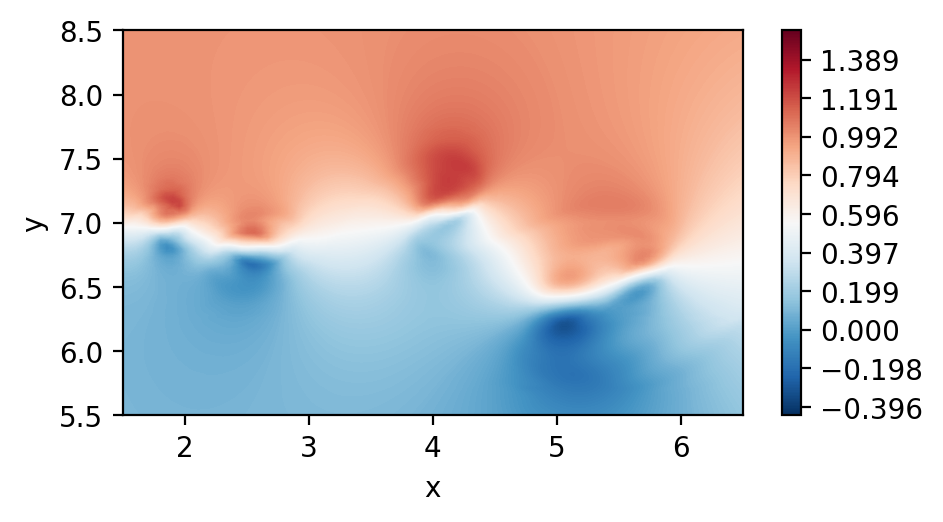

In [9]:
if comm.Get_rank() == 0:

    int_fields = interp_utils.transform_from_list_to_array(nx,ny,nz,probes.interpolated_fields)
    u_int = int_fields[1]

    #levels = 500
    levels = np.linspace(-0.44, 1.54, 500)
    cmapp='RdBu_r'
    fig, ax = plt.subplots(1, 1, figsize=(5, 2.5), dpi = 200)

    c1 = ax.tricontourf(x.flatten(), y.flatten() ,u_int.flatten(), levels=levels, cmap=cmapp)
    fig.colorbar(c1)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    plt.show()